### Imports

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')

from sklearn.preprocessing import MinMaxScaler

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPool2D, Dense
from keras.layers import Flatten, Dropout
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

import os
print(os.listdir("../input/flowerdataset/flowerDataset/"))

Using TensorFlow backend.


['flowers17_training.csv', 'flowers17_testing.csv']


### Load Data

In [2]:
train_df = pd.read_csv("../input/flowerdataset/flowerDataset/flowers17_training.csv", header=None)
test_df = pd.read_csv("../input/flowerdataset/flowerDataset/flowers17_testing.csv", header=None)

In [3]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,12279,12280,12281,12282,12283,12284,12285,12286,12287,12288
0,snowdrop,5,5,30,9,11,33,1,0,14,...,76,47,62,88,40,43,66,62,93,90
1,windflower,51,63,51,27,39,27,14,25,17,...,127,129,161,126,116,155,113,99,143,95
2,tigerlily,202,221,208,70,97,97,152,169,174,...,81,24,93,39,4,34,16,60,146,81
3,tigerlily,15,27,16,15,26,9,2,21,2,...,4,3,16,0,4,18,0,17,24,15
4,windflower,6,10,11,6,10,11,6,10,11,...,0,0,4,3,0,49,35,1,9,5


### Split into train and test data

In [4]:
y_train = train_df[0]
X_train = train_df.drop(columns=[0])
y_test = test_df[0]
X_test = test_df.drop(columns=[0])

### Visualize Data

In [5]:
def get_sample_images(X_train, y_train):
    image_data = []
    labels = []
    print("Loading images for: ", end =" ")
    samples = np.random.choice(len(X_train), 16)
    for sample in samples:
        print("{} |".format(y_train.iloc[sample]), end=" ")
        img = X_train.iloc[sample].values.reshape((64,64,3))
        img = np.flip(img, 2)
        image_data.append(img)
        labels.append(y_train.iloc[sample])
        
    return np.array(image_data), labels

In [6]:
def show_images(images, cols = 1, titles = None):
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: print('Serial title'); titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image, cmap=None)
        a.set_title(title, fontsize=50)
        a.grid(False)
        a.axis("off")
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
plt.show()

In [7]:
images, labels = get_sample_images(X_train, y_train)

Loading images for:  iris | bluebell | crocus | bluebell | bluebell | snowdrop | buttercup | iris | bluebell | lilyvalley | crocus | daisy | crocus | lilyvalley | cowslip | daisy | 

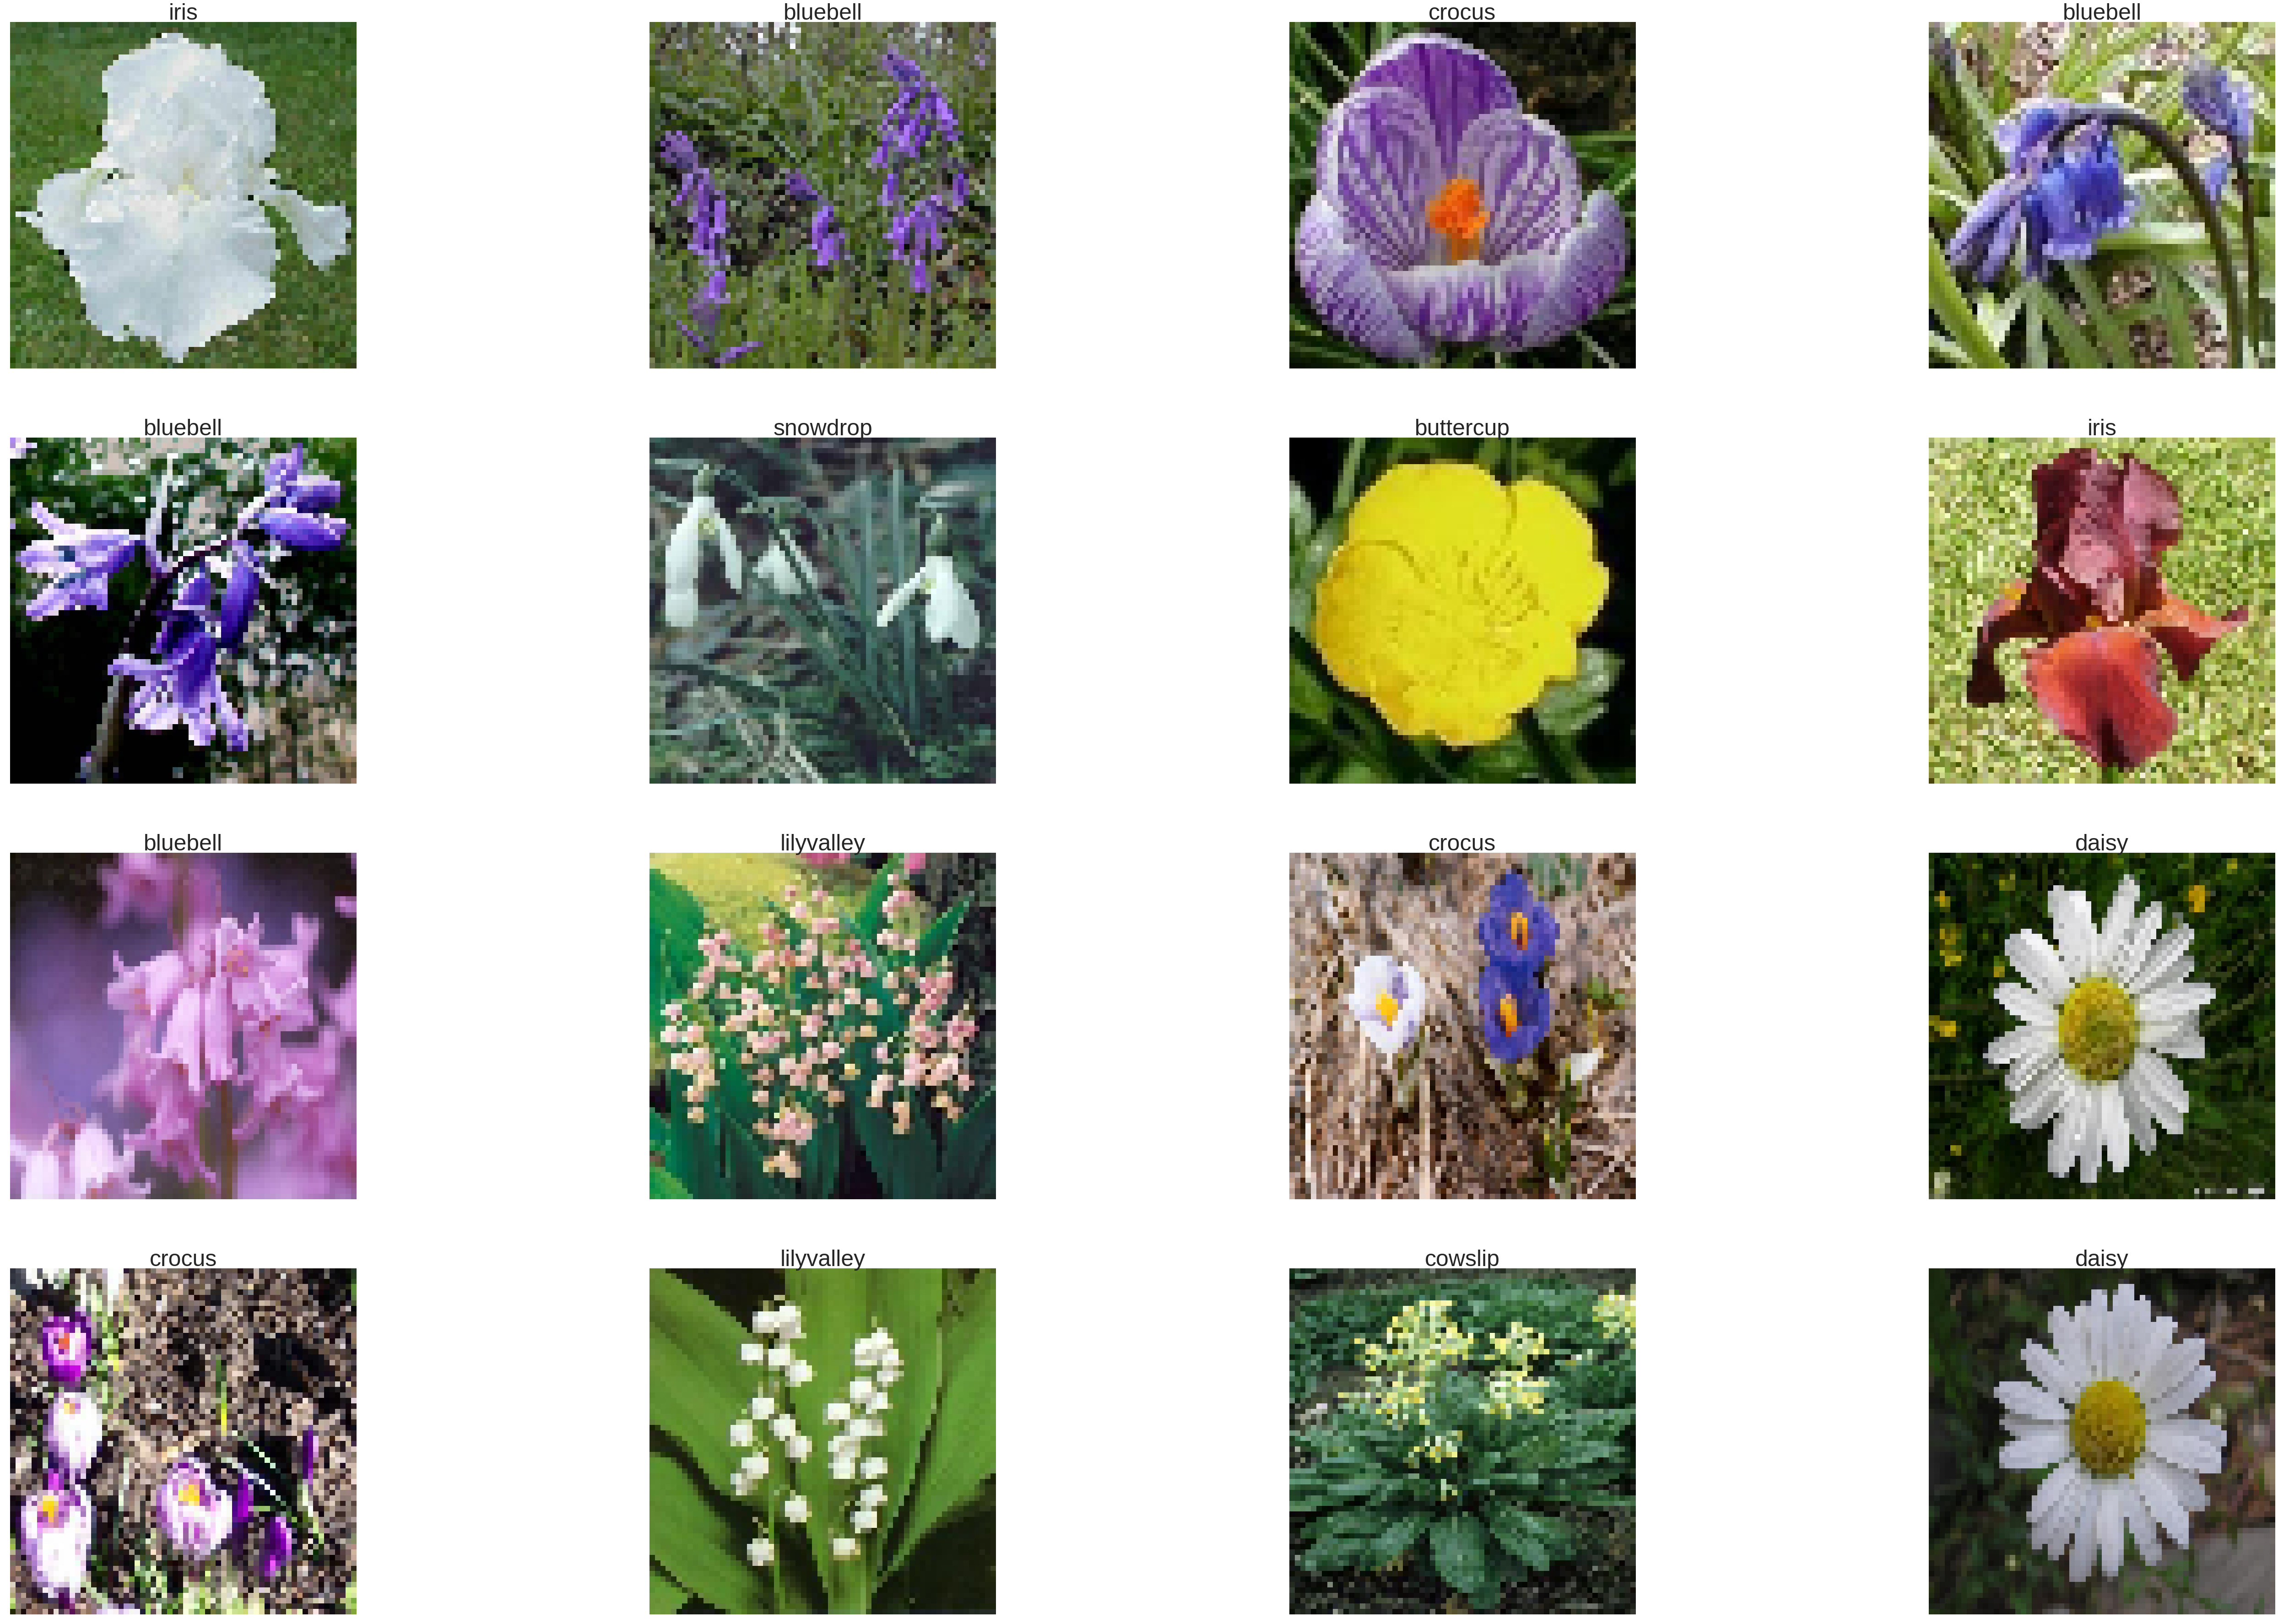

In [8]:
show_images(images, 4, titles=labels)

### Prepare Data

In [9]:
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

In [10]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [11]:
X_train = X_train.reshape((X_train.shape[0], 64,64,3))
X_test = X_test.reshape((X_test.shape[0], 64, 64, 3))

### Image Generator

In [12]:
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15, width_shift_range=0.2, height_shift_range=0.2,
                         shear_range=0.15, horizontal_flip=True, fill_mode="nearest")

### Model Preparation

In [13]:
def modelCNN(inputShape, classes):    
    inputX = Input(inputShape)

    l1 = Conv2D(32, (3, 3), padding="same", activation='relu')(inputX)
    l1 = Conv2D(32, (3, 3), padding="same", activation='relu')(l1)
    l1 = MaxPool2D(pool_size=(2, 2))(l1)
#     l1 = Dropout(0.25)(l1)

    # second CONV => RELU => CONV => RELU => POOL layer set
    l2 = Conv2D(64, (3, 3), padding="same", activation='relu')(l1)
    l2 = Conv2D(64, (3, 3), padding="same", activation='relu')(l2)
    l2 = MaxPool2D(pool_size=(2, 2))(l2)
#     l2 = Dropout(0.25)(l2)

    # third CONV => RELU => CONV => RELU => POOL layer set
    l3 = Conv2D(128, (3, 3), padding="same", activation='relu')(l2)
    l3 = Conv2D(128, (3, 3), padding="same", activation='relu')(l3)
    l3 = MaxPool2D(pool_size=(2, 2))(l3)
#     l3 = Dropout(0.25)(l3)

    # forth CONV => RELU => CONV => RELU => POOL layer set
    l4 = Conv2D(512, (3, 3), padding="same", activation='relu')(l3)
    l4 = Conv2D(512, (3, 3), padding="same", activation='relu')(l4)
    l4 = MaxPool2D(pool_size=(2, 2))(l4)

    # first (and only) set of FC => RELU layers
    l5 = Flatten()(l4)
    l5 = Dropout(0.5)(l5)
    l5 = Dense(512, activation="relu")(l5)

    # softmax classifier
    predictions = Dense(classes, activation="softmax")(l5)
    
    modelCNN = Model(inputs=inputX, outputs=predictions)
    
    return modelCNN

In [14]:
model = modelCNN((64,64,3), 17)

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
__________

### Add sugar and coffee 

In [16]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])

### Callback

In [17]:
earlyStopper = EarlyStopping(monitor='acc', patience=1, restore_best_weights=True)

### Drink 

In [18]:
hist = model.fit_generator(aug.flow(X_train, y_train, batch_size=32),validation_data=(X_test, y_test),
                          steps_per_epoch=len(X_train) // 32, epochs=100)

Epoch 1/100
31/31 [==============================] - 5s 161ms/step - loss: 2.8364 - acc: 0.0494 - val_loss: 2.8350 - val_acc: 0.0441
Epoch 2/100
31/31 [==============================] - 1s 43ms/step - loss: 2.8241 - acc: 0.0619 - val_loss: 2.8063 - val_acc: 0.0618
Epoch 3/100
31/31 [==============================] - 1s 43ms/step - loss: 2.7556 - acc: 0.0949 - val_loss: 2.6108 - val_acc: 0.1059
Epoch 4/100
31/31 [==============================] - 1s 43ms/step - loss: 2.5157 - acc: 0.1313 - val_loss: 2.3445 - val_acc: 0.1529
Epoch 5/100
31/31 [==============================] - 1s 43ms/step - loss: 2.3420 - acc: 0.1648 - val_loss: 2.2493 - val_acc: 0.2118
Epoch 6/100
31/31 [==============================] - 1s 44ms/step - loss: 2.1801 - acc: 0.2114 - val_loss: 2.1538 - val_acc: 0.2206
Epoch 7/100
31/31 [==============================] - 1s 43ms/step - loss: 2.1078 - acc: 0.2484 - val_loss: 1.9032 - val_acc: 0.2912
Epoch 8/100
31/31 [==============================] - 1s 44ms/step - loss: 1

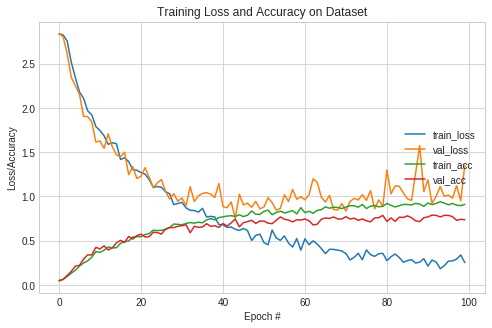

In [19]:
# plot the training loss and accuracy
plt.figure(figsize=(8,5))
plt.plot(hist.history["loss"], label="train_loss")
plt.plot(hist.history["val_loss"], label="val_loss")
plt.plot(hist.history["acc"], label="train_acc")
plt.plot(hist.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right");